# Shape Analysis of Cancer Cells

Lead author: Nina Miolane.

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src="figures/cells_image.png" width=600px />
</center>

Figure 1: Representative images of the cell lines using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

In [1]:
import matplotlib.pyplot as plt

import geomstats.backend as gs
import numpy as np
from nsimplices import *
from scipy.stats.stats import pearsonr   
from common import *

gs.random.seed(2021)

INFO: Using numpy backend


/tmp/ipykernel_2324563/3604342326.py:6: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [2]:
base_path = "/home/wanxinli/dyn/dyn/"
data_path = os.path.join(base_path, "datasets")

dataset_name = 'osteosarcoma'
figs_dir = os.path.join("/home/wanxinli/dyn/dyn/saved_figs", dataset_name)
suffix = 'no_rescale'
print(f"Will save figs to {figs_dir}")

Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma


# 2. Dataset Description

We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*, respectively representing a more agressive and a less agressive cancer.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

Each cell comes from a raw image containing a set of cells, which was thresholded to generate binarized images.

<td>
    <img src="figures/binarized_cells.png" width=400px />
</td>

After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [3]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")

Total number of cells : 650


The cells are grouped by treatment class in the dataset : 
- the *control* cells, 
- the cells treated with *Cytd*,
- and the ones treated with *Jasp*. 

Additionally, in each of these classes, there are two cell lines : 
- the *DLM8* cells, and
- the *DUNN* ones.

This is shown by displaying the unique elements in the lists `treatments` and `lines`:

In [4]:
import pandas as pd

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)
METRICS = ['SRV', 'Linear']

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


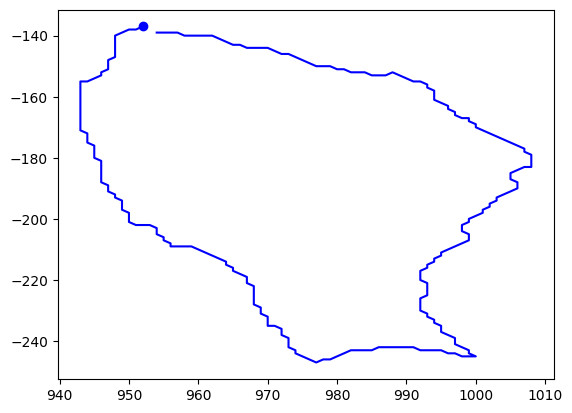

In [5]:
cell_idx = 1
plt.plot(cells[cell_idx][:, 0], cells[cell_idx][:, 1], "blue")
plt.plot(cells[cell_idx][0, 0], cells[cell_idx][0, 1], "blue", marker="o");

The size of each class is displayed below:

In [6]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


The above code also created a dictionnary `ds`, that contains the cell boundaries data sorted by `treatment` and cell `line`. To access all the cells corresponding to a given treatment and a given cell line, we use the syntax `ds[treatment][line]` as in the following code that computes the number of cells in the cytd-dlm8 class.

In [7]:
len(ds["cytd"]["dlm8"])

82

We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [8]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [9]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 200

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

(1116.1964538574218,
 1229.1335021972657,
 -283.2620025634766,
 -199.1779998779297)

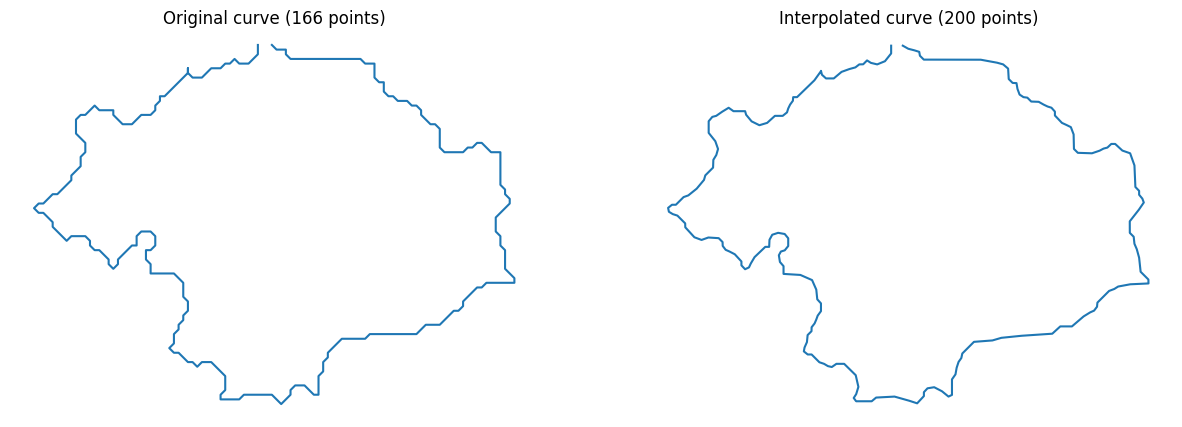

In [10]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

# plt.savefig(os.path.join(figs_dir, "interpolation.svg"))
# plt.savefig(os.path.join(figs_dir, "interpolation.pdf"))

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [11]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

For each key treatment-control, we check that the number of sampling points is the one expected, i.e. `k_sampling_points`:

In [12]:
print(ds_interp["control"]["dunn"].shape)

(204, 200, 2)


The shape of an array of cells in `ds_interp[treatment][cell]` is therefore: `("number of cells in treatment-line", "number of sampling points", 2)`, where 2 refers to the fact that we are considering cell shapes in 2D. 

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (top row shows control, i.e. non-treated cells; bottom rows shows treated cells) across cell lines (left and blue for dlm8 and right and orange for dunn).

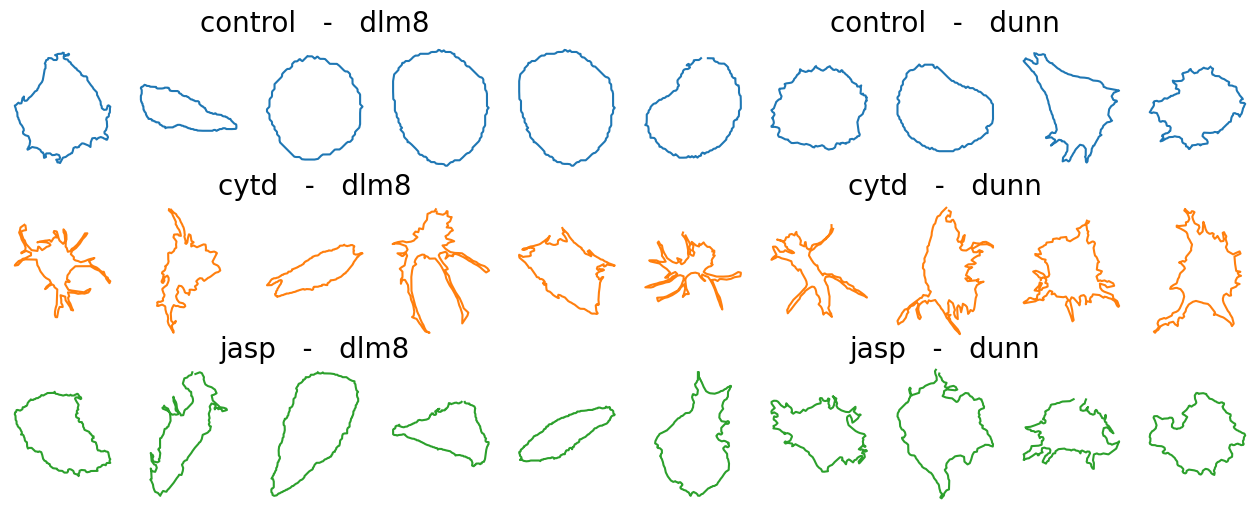

In [13]:
n_cells_to_plot = 5

fig = plt.figure(figsize=(16, 6))
count = 1
for i, treatment in enumerate(TREATMENTS):
    for line in LINES:
        cell_data = ds_interp[treatment][line]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(3, 2 * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color="C" + str(i))
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{treatment}   -   {line}", fontsize=20)
# plt.savefig(os.path.join(figs_dir, "sample_cells.svg"))
# plt.savefig(os.path.join(figs_dir, "sample_cells.pdf"))

Visual inspection of these curves seems to indicate more protusions appearing in treated cells, compared with control ones. This is in agreement with the physiological impact of the drugs, which are known to perturb the internal cytoskeleton connected to the cell membrane. Using the elastic metric, our goal will be to see if we can quantitatively confirm these differences.

### Remove duplicate samples in curves

During interpolation it is likely that some of the discrete curves in the dataset are downsampled from higher number of discrete data points to lower number of data points. Hence, two sampled data points that are close enough may end up overlapping after interpolation and hence such data points have to be dealt with specifically. 

In [14]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

### Alignment

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks. These operations will be performed by leveraging the geometry of the so-called Kendall preshape spaces and specifically its method `PRESHAPE_SPACE.projection`, as shown below. Details on Kendall shape spaces can be found in the [module implementing them](https://github.com/geomstats/geomstats/blob/master/geomstats/geometry/pre_shape.py) or the notebooks using them. 

Additionally, since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). This exhaustive search is implemented in the function `exhaustive_align` below.

In [15]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=k_sampling_points)

PRESHAPE_SPACE.equip_with_group_action("rotations")
PRESHAPE_SPACE.equip_with_quotient_structure()


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.fiber_bundle.align(point=gs.array(reparametrized), base_point=base_curve)
        distances[shift] = PRESHAPE_SPACE.embedding_space.metric.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.fiber_bundle.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve

We perform the pre-shape projection and the exhaustive alignment of the cells against the base curve, which is chosen to be the first cell curve of the dataset, called `BASE_CURVE`. 

Both the projection and the alignment make use of our auxiliary function `apply_func_to_ds`, which finally outputs a dataset of cell curves organized within a dictionnary called `ds_align`.

In [16]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

ds_proj = apply_func_to_ds(ds_proc, func= lambda x: PRESHAPE_SPACE.projection(x, rescale=False))
print(ds_proj["control"]["dunn"].shape)

BASE_CURVE = ds_proj["control"]["dunn"][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
print(ds_align["control"]["dunn"].shape)

(204, 200, 2)
Shape of BASE_CURVE: (200, 2)


(204, 200, 2)


We visually evaluate that methods perform correctly, by plotting the results of the projection and the alignment through the following code.

Text(0.5, 1.0, 'Aligned curve')

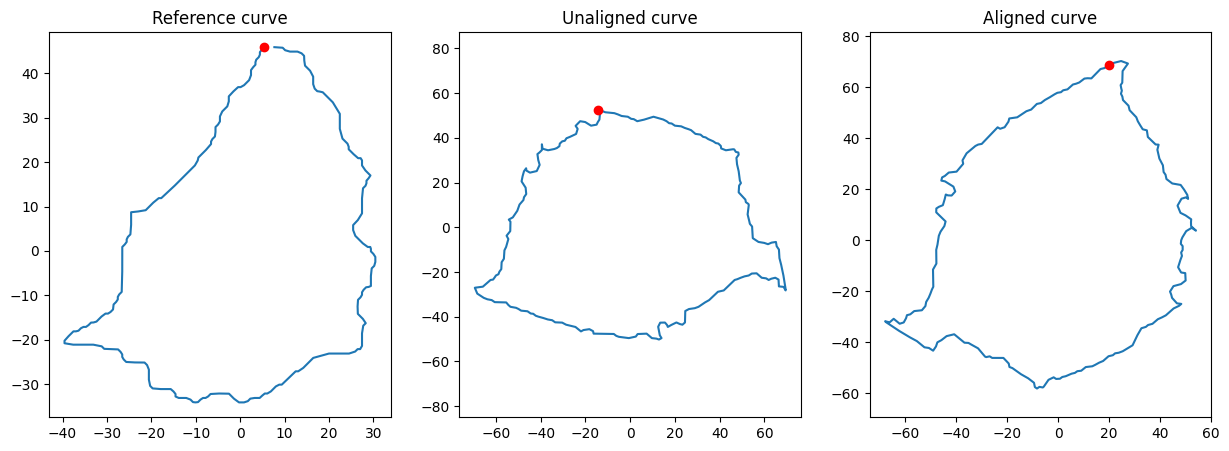

In [17]:
i_rand = gs.random.randint(n_cells_df.loc["control"]["dunn"])
unaligned_cell = ds_proj["control"]["dunn"][i_rand]
aligned_cell = ds_align["control"]["dunn"][i_rand]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

# plt.savefig(os.path.join(figs_dir, "alignment.svg"))
# plt.savefig(os.path.join(figs_dir, "alignment.pdf"))


In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

# 4 Data Analysis

## Compute Mean Cell Shape of the Whole Dataset: "Global" Mean Shape

We want to compute the mean cell shape of the whole dataset. Thus, we first combine all the cell shape data into a single array.

In [18]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves, L2CurvesMetric


CURVES_SPACE_SRV = DiscreteCurves(Euclidean(dim=2), k_sampling_points=200)


In [19]:
cell_shapes_list = []
for treatment in TREATMENTS:
    for line in LINES:
        cell_shapes_list.extend(ds_align[treatment][line])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(650, 200, 2)


Remove outliers using DeCOr-MDS, separately for DUNN and DLM8 cell lines.

In [20]:
# def srv_dist(cell1, cell2):
#     return CURVES_SPACE_SRV.metric.dist(cell1, cell2) / k_sampling_points
 
# compute pairwise distances
# pairwise_dists = parallel_dist(cell_shapes, srv_dist, k_sampling_points)

# # run DeCOr-MDS
# dim_start = 2
# dim_end = 2
# feature_num = 2
# outlier_indices, subspace_dim , corr_pairwise_dis, corr_coord = nsimplices(pairwise_dists, feature_num, dim_start, dim_end, std_multi=3)
# print(f"outlier_indices are: {outlier_indices}")

Visualize outlier cells to see if they are artifacts

In [21]:
# fig, axes = plt.subplots(
#     nrows= 1,
#     ncols=len(outlier_indices),
#     figsize=(2*len(outlier_indices), 2),
# )


# for i, outlier_index in enumerate(outlier_indices):
#     one_cell = cell_shapes[outlier_index]
#     ax = axes[i]
#     ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
#     ax.set_title(f"{outlier_index}", fontsize=14)
#     # ax.axis("off")
#     # Turn off tick labels
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.spines["left"].set_visible(False)

# plt.tight_layout()
# plt.suptitle(f"", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "outlier.svg"))

Text(0.5, -0.01, '')

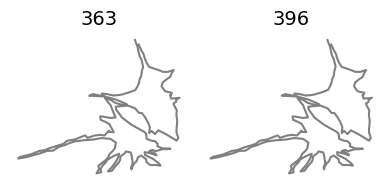

In [22]:
delete_indices = [363, 396]

fig, axes = plt.subplots(
    nrows= 1,
    ncols=len(delete_indices),
    figsize=(2*len(delete_indices), 2),
)


for i, outlier_index in enumerate(delete_indices):
    one_cell = cell_shapes[outlier_index]
    ax = axes[i]
    ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"gray")
    ax.set_title(f"{outlier_index}", fontsize=14)
    # ax.axis("off")
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.suptitle(f"", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "delete_outlier.svg"))
# plt.savefig(os.path.join(figs_dir, "delete_outlier.pdf"))

After visual inspection, we decide to remove 363, 396th cell

In [23]:
cells, cell_shapes, lines, treatments, ds_proc, ds_proj, ds_align = remove_cells_two_layer(cells, cell_shapes, lines, treatments, ds_proc, ds_proj, ds_align, delete_indices)

Calculate the perimeters for all cells 

In [24]:
def calc_perimeter(point):
    total_space_metric = PRESHAPE_SPACE._get_total_space_metric()
    centered_point = PRESHAPE_SPACE.center(point)
    frob_norm = total_space_metric.norm(centered_point)
    return frob_norm

In [25]:
ds_perimeter = apply_func_to_ds(ds_proc, func= lambda x: calc_perimeter(x))

In [26]:
print(f'Number of cells: {len(cells)}, Number of lines: {len(lines)}, Shape of cell_shapes: {cell_shapes.shape}')
for treatment, treatment_values in ds_align.items():
    for line, line_cells in treatment_values.items():
        print(f"Treatment: {treatment}, Cell line {line}: {len(line_cells)}")

Number of cells: 648, Number of lines: 648, Shape of cell_shapes: (648, 200, 2)
Treatment: control, Cell line dlm8: 114
Treatment: control, Cell line dunn: 204
Treatment: cytd, Cell line dlm8: 80
Treatment: cytd, Cell line dunn: 93
Treatment: jasp, Cell line dlm8: 62
Treatment: jasp, Cell line dunn: 95


We compute the mean cell shape by using the SRV metric defined on the space of curves' shapes. The space of curves' shape is a manifold: we use the Frechet mean, associated to the SRV metric, to get the mean cell shape.

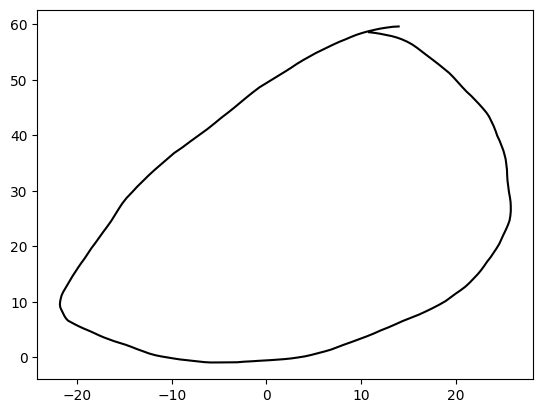

In [27]:
from geomstats.learning.frechet_mean import FrechetMean

mean = FrechetMean(space=CURVES_SPACE_SRV)
mean.fit(cell_shapes)

mean_estimate = mean.estimate_

plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black");

The mean cell shape does indeed look like a cell shape. We note that there is a discontinuity in the cell because we have modeled the curves' boundaries as open curves. The space of curves considered here is also the space of (open) discrete curves.

Unfortunately, sometimes there could be Nans in the values of the mean shape. If this is the case, this code removes them manually, and re-interpolate the mean shape.

In [28]:
print(gs.sum(gs.isnan(mean_estimate)))
mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
print(mean_estimate_clean.shape)
mean_estimate_clean = interpolate(mean_estimate_clean, k_sampling_points)
print(gs.sum(gs.isnan(mean_estimate_clean)))
print(mean_estimate_clean.shape)

0
(200, 2)
0
(200, 2)


We plot the mean cell shape, superimposed on top of the dataset of cells (displayed in light grey underneath).

(648, 200, 2)


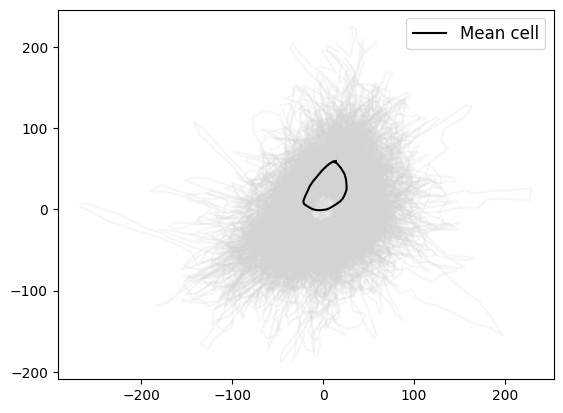

In [29]:
print(cell_shapes.shape)
for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_clean[:, 0], mean_estimate_clean[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We see that the scale and alignment of the mean shape is slightly off. This makes sense, as our computations have quotiented out scale and alignment. We correct it manually.

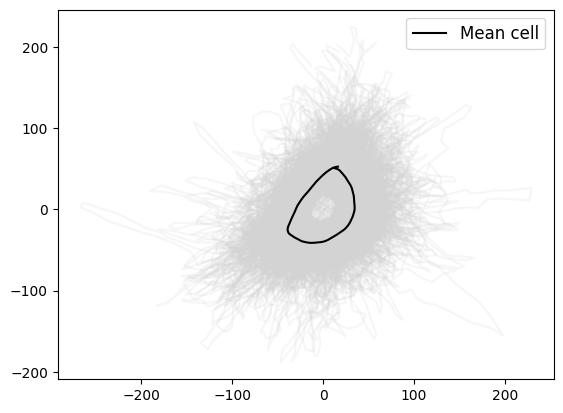

In [30]:
mean_estimate_aligned = 1.55 * (
    mean_estimate_clean - gs.mean(mean_estimate_clean, axis=0)
)

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We visualize the same plot, but now:
- closing the mean shape that becomes a closed curve
- plotting underneath the mean shape the distribution of the sampling points of all the curves of the dataset, through a kernel density estimation.

Visualizing the full datasets of 640+ cells takes a long time. Therefore, we also select only 200 cells, randomly, within the dataset.

In [31]:
mean_estimate_aligned_bis = gs.vstack(
    [mean_estimate_aligned[4:], mean_estimate_aligned[-1]]
)

Text(0.5, 1.0, 'Global mean shape superimposed on the\n dataset of cells')

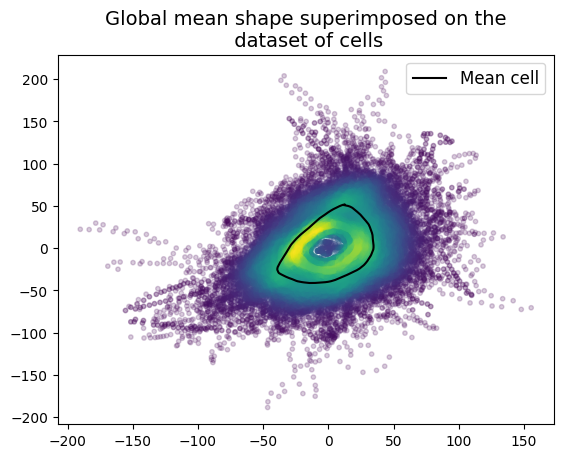

In [32]:
from scipy.stats import gaussian_kde

cells_to_plot = cell_shapes[gs.random.randint(len(cell_shapes), size=200)]
points_to_plot = cells_to_plot.reshape(-1, 2)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()

plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], alpha=0.2, c=z_norm, s=10)
plt.plot(
    mean_estimate_aligned_bis[:, 0],
    mean_estimate_aligned_bis[:, 1],
    "black",
    label="Mean cell",
)
plt.legend(fontsize=12)
plt.title("Global mean shape superimposed on the\n dataset of cells", fontsize=14)

# plt.savefig("global_mean_shape.svg")

This plot allows to verify that the mean shape that has been computed makes sense.

Also we compute the linear mean

0
(200, 2)
0
(200, 2)


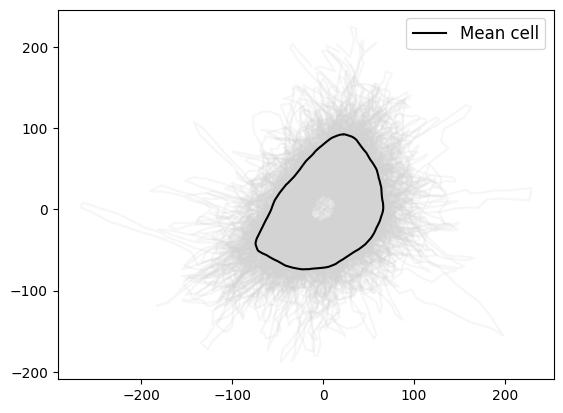

In [33]:
linear_mean_estimate = gs.mean(cell_shapes, axis=0)
print(gs.sum(gs.isnan(linear_mean_estimate)))
linear_mean_estimate_clean = linear_mean_estimate[~gs.isnan(gs.sum(linear_mean_estimate, axis=1)), :]
print(linear_mean_estimate_clean.shape)

linear_mean_estimate_clean = interpolate(linear_mean_estimate_clean, k_sampling_points)

print(gs.sum(gs.isnan(linear_mean_estimate_clean)))
print(linear_mean_estimate_clean.shape)

linear_mean_estimate_aligned = 1.55 * (
    linear_mean_estimate_clean - gs.mean(linear_mean_estimate_clean, axis=0)
)

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    linear_mean_estimate_aligned[:, 0], linear_mean_estimate_aligned[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

Plot SRV mean cell versus linear mean cell

(-81.48193597949859, 73.12762167376484, -82.0023922784939, 100.7146643182335)

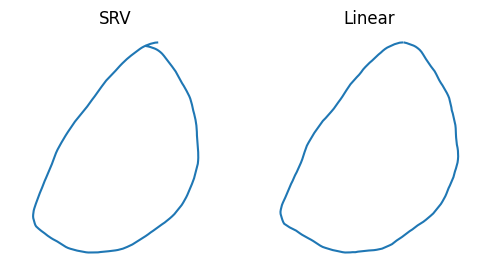

In [34]:
fig = plt.figure(figsize=(6, 3))

fig.add_subplot(121)
plt.plot(mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1])
plt.axis("equal")
plt.title("SRV")
plt.axis("off")

fig.add_subplot(122)
plt.plot(linear_mean_estimate_aligned[:, 0], linear_mean_estimate_aligned[:, 1])
plt.axis("equal")
plt.title("Linear")
plt.axis("off")

# plt.savefig(os.path.join(figs_dir, "global_mean.svg"))
# plt.savefig(os.path.join(figs_dir, "global_mean.pdf"))



Not sure how but the 1.55 makes the seperation of the histogram better, though it does not look like the mean of the cell shapes.

# Analyze Distances to the "Global"  Mean Shape

We consider each of the subgroups of cells, defined by their treatment and cell line. We wish to study how far each of this group is from the global mean shape. We compute the list of distances to the global mean shape.

In [35]:
metric = 'SRV'
dists_to_global_mean = {}
dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align, func=lambda x: CURVES_SPACE_SRV.metric.dist(x, mean_estimate_aligned)
)

dists_to_global_mean_list = {}
dists_to_global_mean_list[metric] = []
for t in TREATMENTS:
    for l in LINES:
        dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][t][l])

We plot the distances to the mean global shape, by splitting them into the three treatment groups.

In [36]:
from scipy import stats

Compute distances to linear mean

In [37]:
metric = 'Linear'
dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align, func=lambda x: gs.linalg.norm(linear_mean_estimate_aligned - x) 
)

In [38]:
dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align, func=lambda x: gs.linalg.norm(linear_mean_estimate_aligned - x) 
)

dists_to_global_mean_list[metric] = []
for t in TREATMENTS:
    for l in LINES:
        dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][t][l])

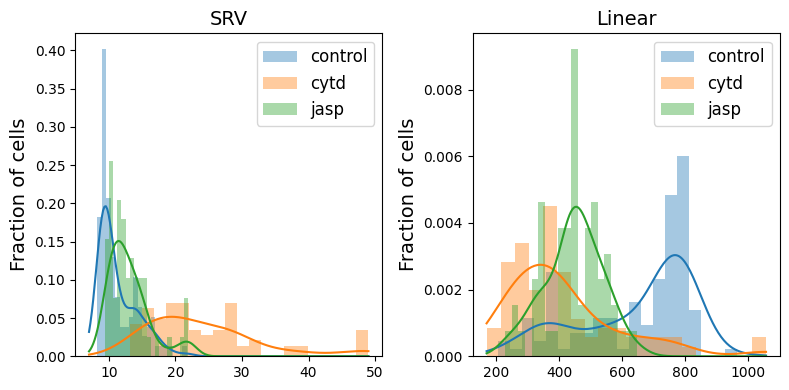

In [39]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

line = 'dlm8'
for j, metric in enumerate(METRICS):
    distances = []
    min_dists = min(dists_to_global_mean_list[metric])
    max_dists = max(dists_to_global_mean_list[metric])
    xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)
    
    for i, treatment in enumerate(TREATMENTS):
        distances = dists_to_global_mean[metric][treatment][line][~gs.isnan(dists_to_global_mean[metric][treatment][line])]
        axs[j].hist(distances, bins=20, alpha=0.4, density=True, label=treatment, color=f"C{i}")
        kde = stats.gaussian_kde(distances)
        axs[j].plot(xx, kde(xx), color=f"C{i}")
        # axs[j].set_xlim((min_dists, max_dists))
        axs[j].legend(fontsize=12)

        axs[j].set_title(f"{metric}", fontsize=14)
        axs[j].set_ylabel("Fraction of cells", fontsize=14)


# fig.suptitle("Histograms of SRV distances to global mean cell", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_histogram_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_histogram_{suffix}.pdf"))


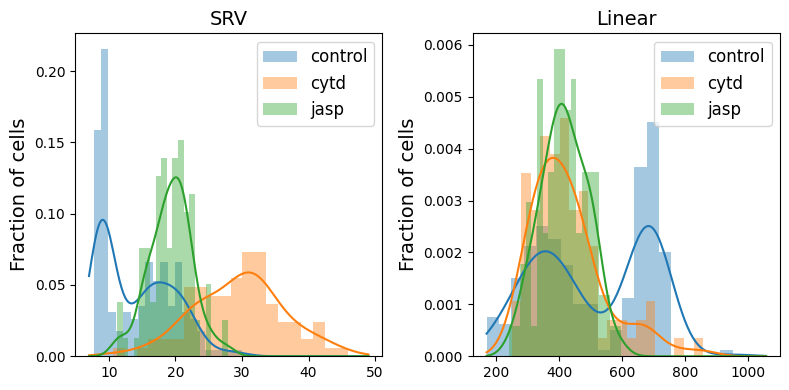

In [40]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

line = 'dunn'
for j, metric in enumerate(METRICS):
    distances = []
    min_dists = min(dists_to_global_mean_list[metric])
    max_dists = max(dists_to_global_mean_list[metric])
    xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)
    
    for i, treatment in enumerate(TREATMENTS):
        distances = dists_to_global_mean[metric][treatment][line][~gs.isnan(dists_to_global_mean[metric][treatment][line])]
        axs[j].hist(distances, bins=20, alpha=0.4, density=True, label=treatment, color=f"C{i}")
        kde = stats.gaussian_kde(distances)
        axs[j].plot(xx, kde(xx), color=f"C{i}")
        # axs[j].set_xlim((min_dists, max_dists))
        axs[j].legend(fontsize=12)

        axs[j].set_title(f"{metric}", fontsize=14)
        axs[j].set_ylabel("Fraction of cells", fontsize=14)


# fig.suptitle("Histograms of SRV distances to global mean cell", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_histogram_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_histogram_{suffix}.pdf"))


Assess the correlation between distances to the global mean and cell perimeters

The Pearson coefficient between distances and perimeters is 0.84


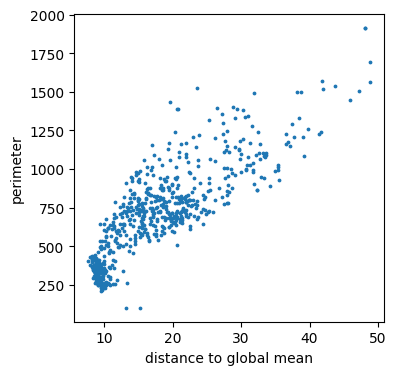

In [41]:

all_distances = []
all_perimeters = []

plt.figure(figsize=(4,4))

for line in LINES:
    for treatment in TREATMENTS:
        distances = dists_to_global_mean['SRV'][treatment][line]
        perimeters = ds_perimeter[treatment][line]
        all_distances.extend(distances)
        all_perimeters.extend(perimeters)
        plt.scatter(distances, perimeters, s=3, c='tab:blue')

plt.xlabel("distance to global mean")
plt.ylabel("perimeter")

coef, _ = pearsonr(all_distances, all_perimeters)

print(f"The Pearson coefficient between distances and perimeters is {round(coef, 2)}")
plt.savefig(os.path.join(figs_dir, f"global_distance_perimeter.svg"))
plt.savefig(os.path.join(figs_dir, f"global_distance_perimeter.pdf"))

Let's analyze bi-modal distribution for the control group of dunn cell line using SRV metric

We consider two groups: cells with 0-0.5 distance to the mean, cells with > 0.5 distance to the mean

7.678243752318799 29.954241769400817


(-29.45366226099941, 31.292059292364534, -8.972316209757661, 66.98600275507124)

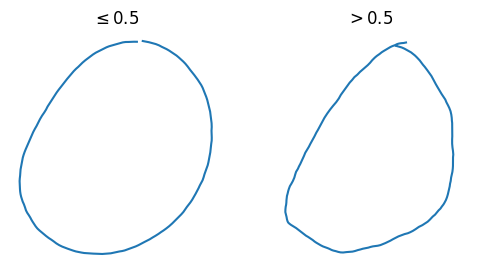

In [42]:
line = 'dunn'
treatment = 'control'
metric = 'SRV'
distances = dists_to_global_mean[metric][treatment][line]
print(min(distances), max(distances))
threshold = 12
group_1_indices = [i for i, element in enumerate(distances) if element <= threshold]
group_2_indices = [i for i, element in enumerate(distances) if element > threshold]
group_1_cells = ds_align[treatment][line][group_1_indices,:,:]
group_2_cells = ds_align[treatment][line][group_2_indices,:,:]
group_1_mean = FrechetMean(space=CURVES_SPACE_SRV)
group_1_mean.fit(group_1_cells)
group_1_mean_estimate = group_1_mean.estimate_
group_2_mean = FrechetMean(space=CURVES_SPACE_SRV)
group_2_mean.fit(group_2_cells)
group_2_mean_estimate = group_2_mean.estimate_

fig = plt.figure(figsize=(6, 3))

fig.add_subplot(121)
plt.plot(group_1_mean_estimate[:, 0], group_1_mean_estimate[:, 1])
ax.set_xlim(-170, 170)
ax.set_ylim(-170, 170)
plt.axis("equal")
plt.title(r"$\leq 0.5$")
plt.axis("off")

fig.add_subplot(122)
plt.plot(group_2_mean_estimate[:, 0], group_2_mean_estimate[:, 1])
ax.set_xlim(-170, 170)
ax.set_ylim(-170, 170)
plt.axis("equal")
plt.title(r"$> 0.5$")
plt.axis("off")

# plt.savefig(os.path.join(figs_dir, f"{line}_bimodal_mean.svg"))
# plt.savefig(os.path.join(figs_dir, f"{line}_bimodal_mean.pdf"))

# Visualization of the Mean of each Treatment

The mean distances to the global mean shape differ. We also plot the mean shape for each of the subgroup, to get intuition on how the mean shape of each subgroup looks like.

We first calculate the SRV mean

In [43]:
mean_treatment_cells = {}
for treatment in TREATMENTS:
    treatment_cells = []
    for line in LINES:
        treatment_cells.extend(ds_align[treatment][line])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(gs.array(treatment_cells[:30]))
    mean_treatment_cells[treatment] = mean_estimator.estimate_

In [44]:
mean_line_cells = {}
for line in LINES:
    line_cells = []
    for treatment in TREATMENTS:
        line_cells.extend(ds_align[treatment][line])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(gs.array(line_cells[:225]))
    mean_line_cells[line] = mean_estimator.estimate_

In [45]:
mean_cells = {}
metric = 'SRV'
mean_cells[metric] = {}
for treatment in TREATMENTS:
    mean_cells[metric][treatment] = {}
    for line in LINES:
        mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
        mean_estimator.fit(gs.array(ds_align[treatment][line][:20]))
        mean_cells[metric][treatment][line] = mean_estimator.estimate_

We then calculate the linear mean

In [46]:
metric = 'Linear'
mean_cells[metric] = {}
for treatment in TREATMENTS:
    mean_cells[metric][treatment] = {}
    for line in LINES:
        mean_cells[metric][treatment][line] = gs.mean(ds_align[treatment][line], axis=0)

While the mean shapes of the control groups (for both cell lines) look regular, we observe that:
- the mean shape for cytd is the most irregular (for both cell lines)
- while the mean shape for jasp is more elongated for dlm8 cell line, and more irregular for dunn cell line.

# Distance of the Cell Shapes to their Own Mean Shape

Lastly, we evaluate how each subgroup of cell shapes is distributed around the mean shape of their specific subgroup.

In [47]:
dists_to_own_mean = {}

nan_ids = {}
for metric in METRICS:
    dists_to_own_mean[metric] = {}
    for treatment in TREATMENTS:
        dists_to_own_mean[metric][treatment] = {}
        nan_ids[treatment] = {}
        for line in LINES:
            dists = []
            ids = []
            for i_curve, curve in enumerate(ds_align[treatment][line]):
                if metric == 'SRV':
                    one_dist = CURVES_SPACE_SRV.metric.dist(curve, mean_cells[metric][treatment][line])
                else:
                    one_dist = gs.linalg.norm(curve - mean_cells[metric][treatment][line])
                if ~gs.isnan(one_dist):
                    dists.append(one_dist)
                else:
                    ids.append(i_curve)
            dists_to_own_mean[metric][treatment][line] = dists
            nan_ids[treatment][line] = ids

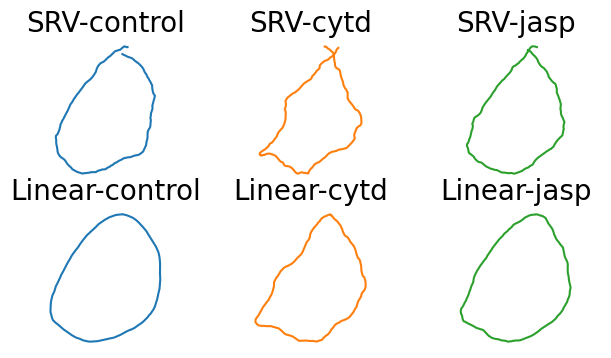

In [48]:
line = 'dunn'

fig, axes = plt.subplots(
    ncols=len(TREATMENTS),
    nrows=len(METRICS),
    figsize=(2.5*len(TREATMENTS), 2*len(METRICS)))

for j, metric in enumerate(METRICS):
    for i, treatment in enumerate(TREATMENTS):
        ax = axes[j, i]
        mean_cell = mean_cells[metric][treatment][line]
        ax.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C{i}")
        ax.set_xlim(-170, 170)
        ax.set_ylim(-170, 170)
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(f"{metric}-{treatment}", fontsize=20)
# plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.svg"))
# plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.pdf"))

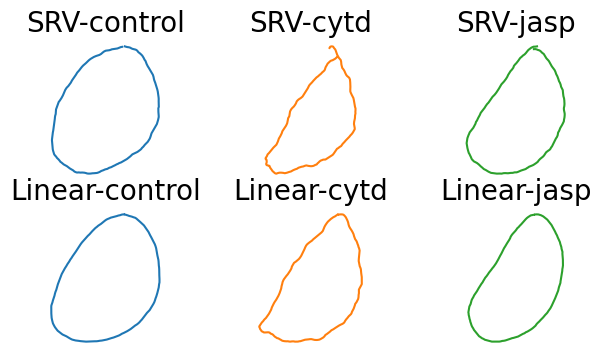

In [49]:
line = 'dlm8'

fig, axes = plt.subplots(
    ncols=len(TREATMENTS),
    nrows=len(METRICS),
    figsize=(2.5*len(TREATMENTS), 2*len(METRICS)))

for j, metric in enumerate(METRICS):
    for i, treatment in enumerate(TREATMENTS):
        ax = axes[j, i]
        mean_cell = mean_cells[metric][treatment][line]
        ax.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C{i}")
        ax.set_xlim(-170, 170)
        ax.set_ylim(-170, 170)
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(f"{metric}-{treatment}", fontsize=20)
# plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.svg"))
# plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.pdf"))

The above code find a given number of quantiles within the distance's histogram, using SRV metric and own mean, and plots the corresponding cell, for each treatment and each cell line.

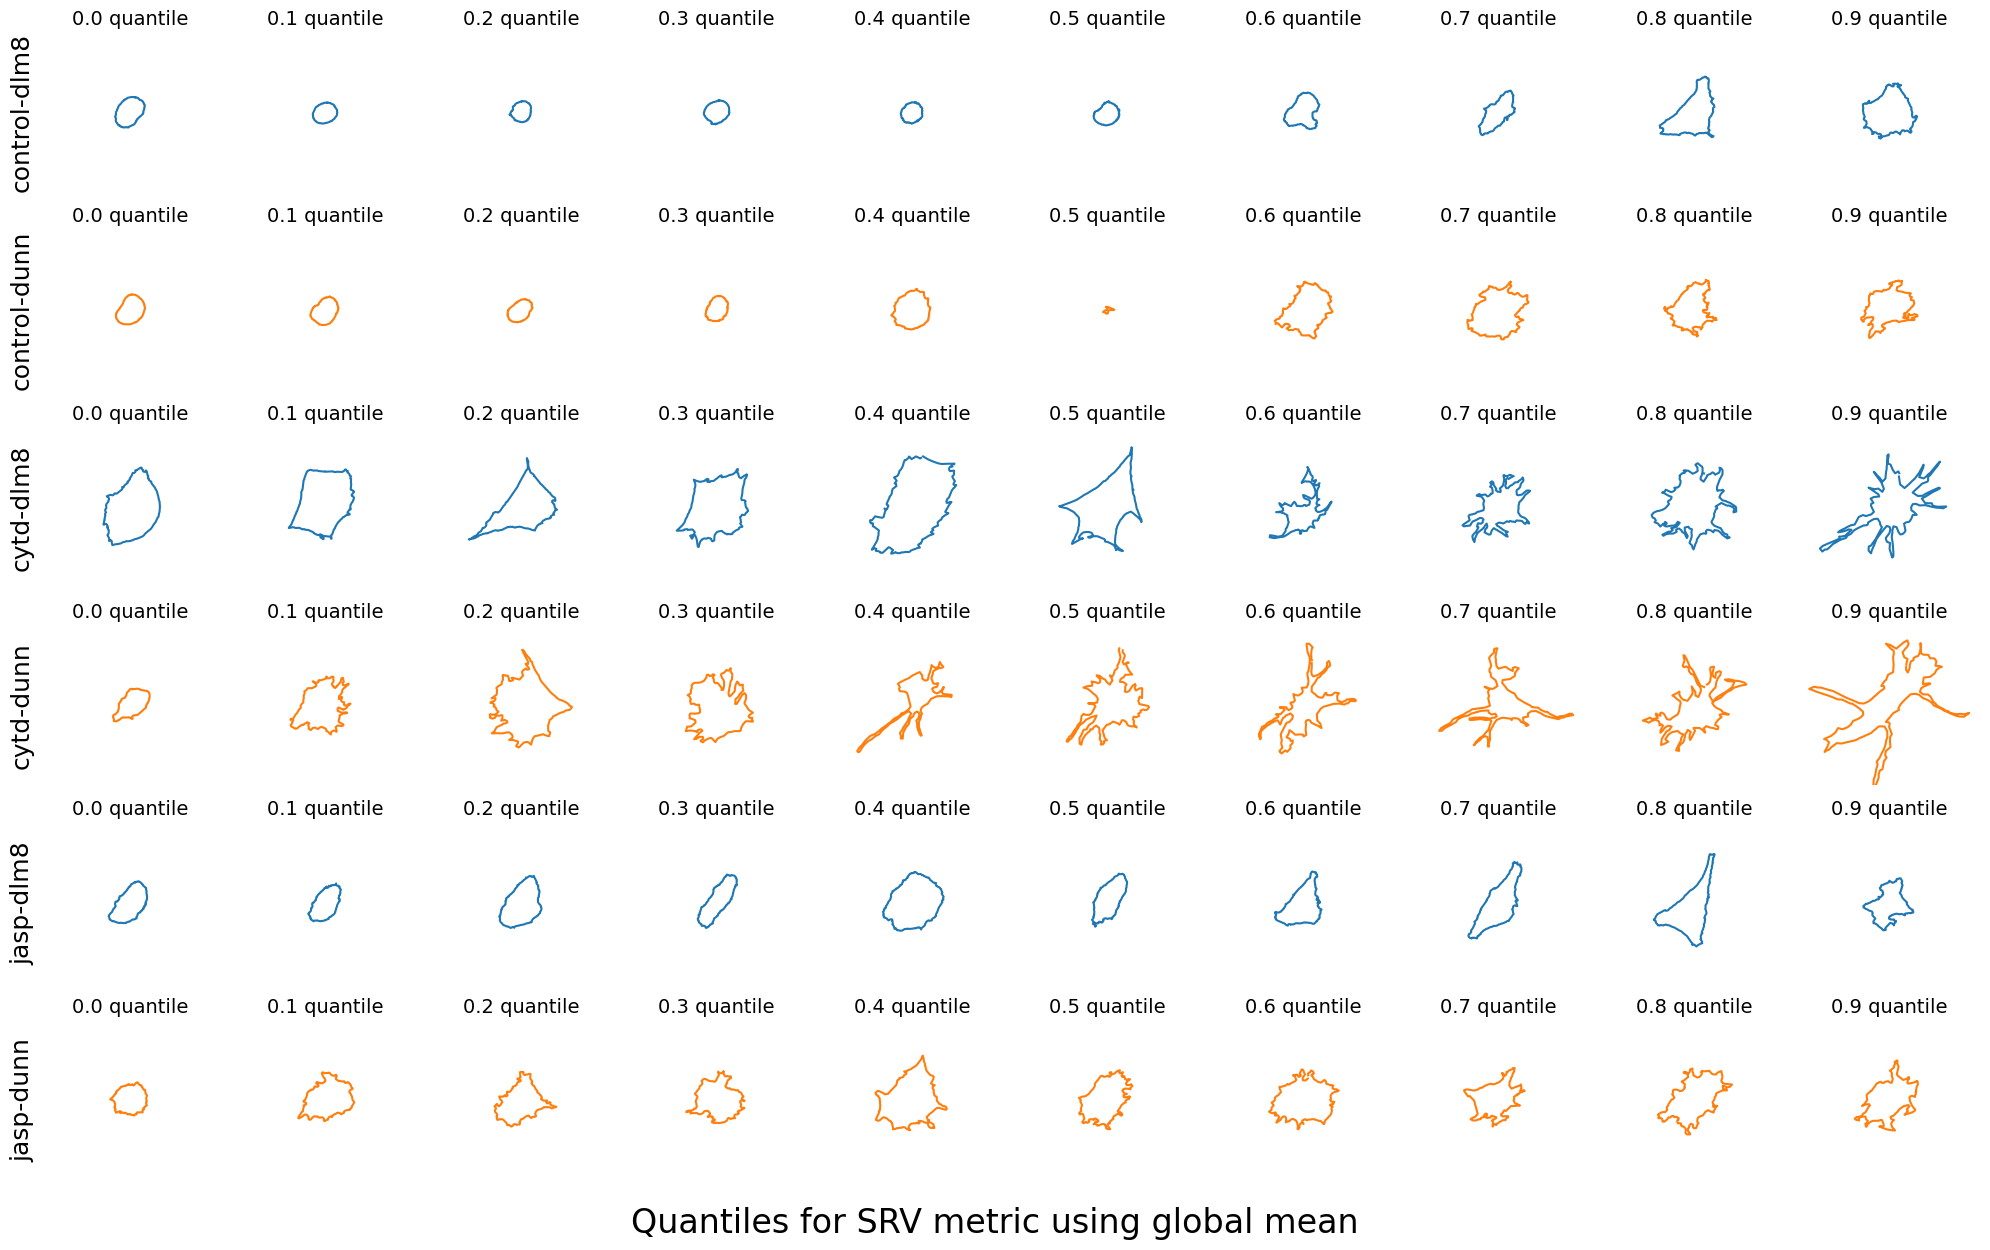

In [50]:
n_quantiles = 10
fig, axes = plt.subplots(
    nrows=len(TREATMENTS) * len(LINES),
    ncols=n_quantiles,
    figsize=(20, 2 * len(LINES) * len(TREATMENTS)),
)

for i, treatment in enumerate(TREATMENTS):
    for j, line in enumerate(LINES):
        dists_list = dists_to_global_mean['SRV'][treatment][line]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[treatment][line])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2 * i + j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            ax.set_xlim(-170, 170)
            ax.set_ylim(-170, 170)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
          

            if i_quantile == 0:
                ax.set_ylabel(f"{treatment}-{line}", rotation=90, fontsize=18)
plt.tight_layout()
plt.suptitle(f"Quantiles for SRV metric using global mean", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, f"quantiles_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"quantiles_{suffix}.pdf"))

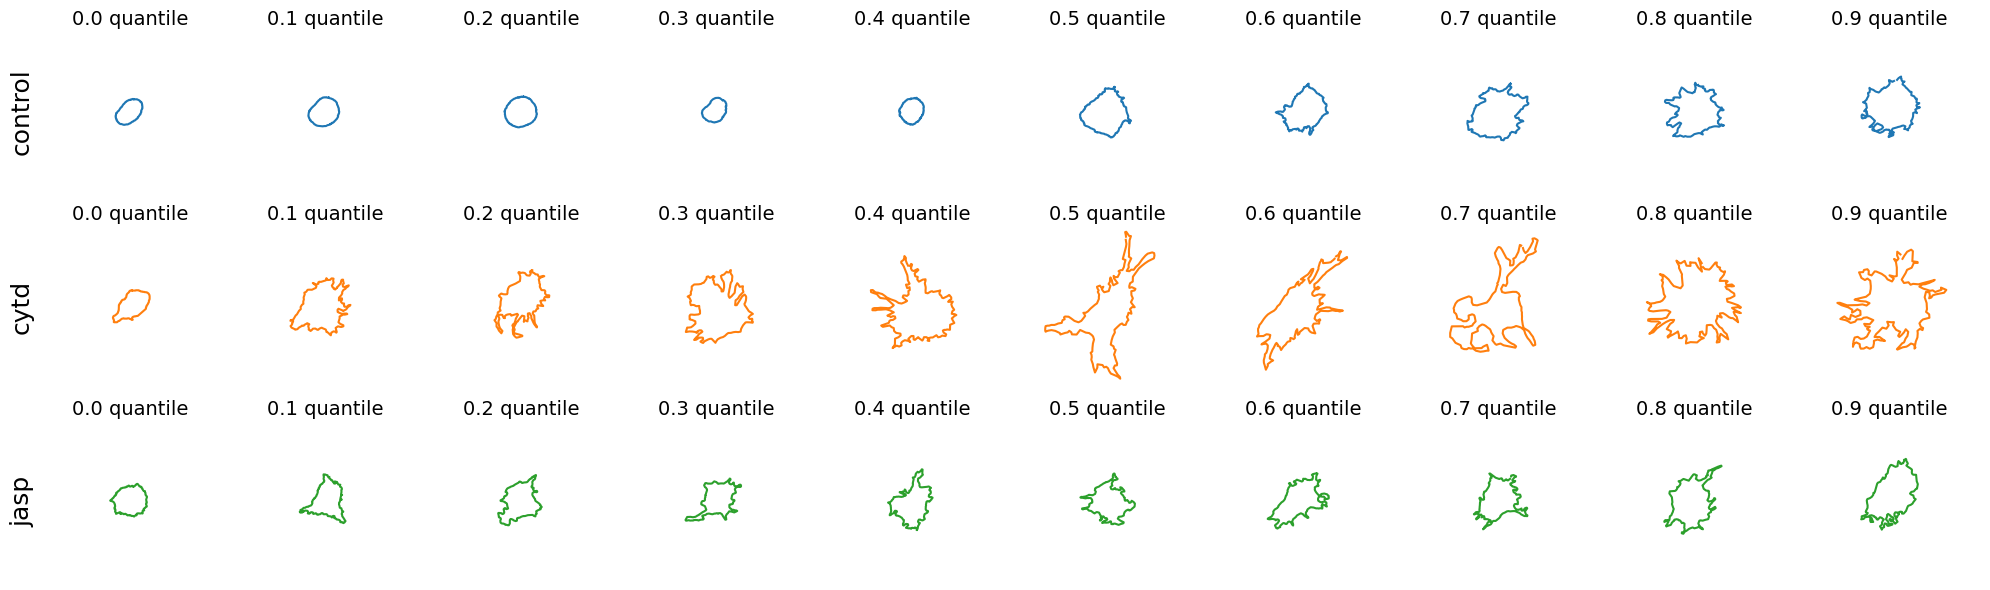

In [51]:
line = 'dunn'
n_quantiles = 10

fig, axes = plt.subplots(
    nrows=len(TREATMENTS),
    ncols=n_quantiles,
    figsize=(20, 2 * len(TREATMENTS)),
)

metric = 'SRV'
for i, treatment in enumerate(TREATMENTS):
    dists_list = dists_to_own_mean[metric][treatment][line]
    dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
    cells_list = list(ds_align[treatment][line])
    assert len(dists_list) == len(dists_list)
    n_cells = len(dists_list)

    zipped_lists = zip(dists_list, cells_list)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
    for i_quantile in range(n_quantiles):
        quantile = int(0.1 * n_cells * i_quantile)
        one_cell = sorted_cells_list[quantile]
        ax = axes[i, i_quantile]
        ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{i}")
        ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
        ax.set_xlim(-170, 170)
        ax.set_ylim(-170, 170)
        # ax.axis("off")
        # Turn off tick labels
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
          

        if i_quantile == 0:
            ax.set_ylabel(f"{treatment}", rotation=90, fontsize=18)
plt.tight_layout()
# plt.suptitle(f"Quantiles for linear metric using own mean", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, f"{line}_quantile_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_quantile_{suffix}.pdf"))


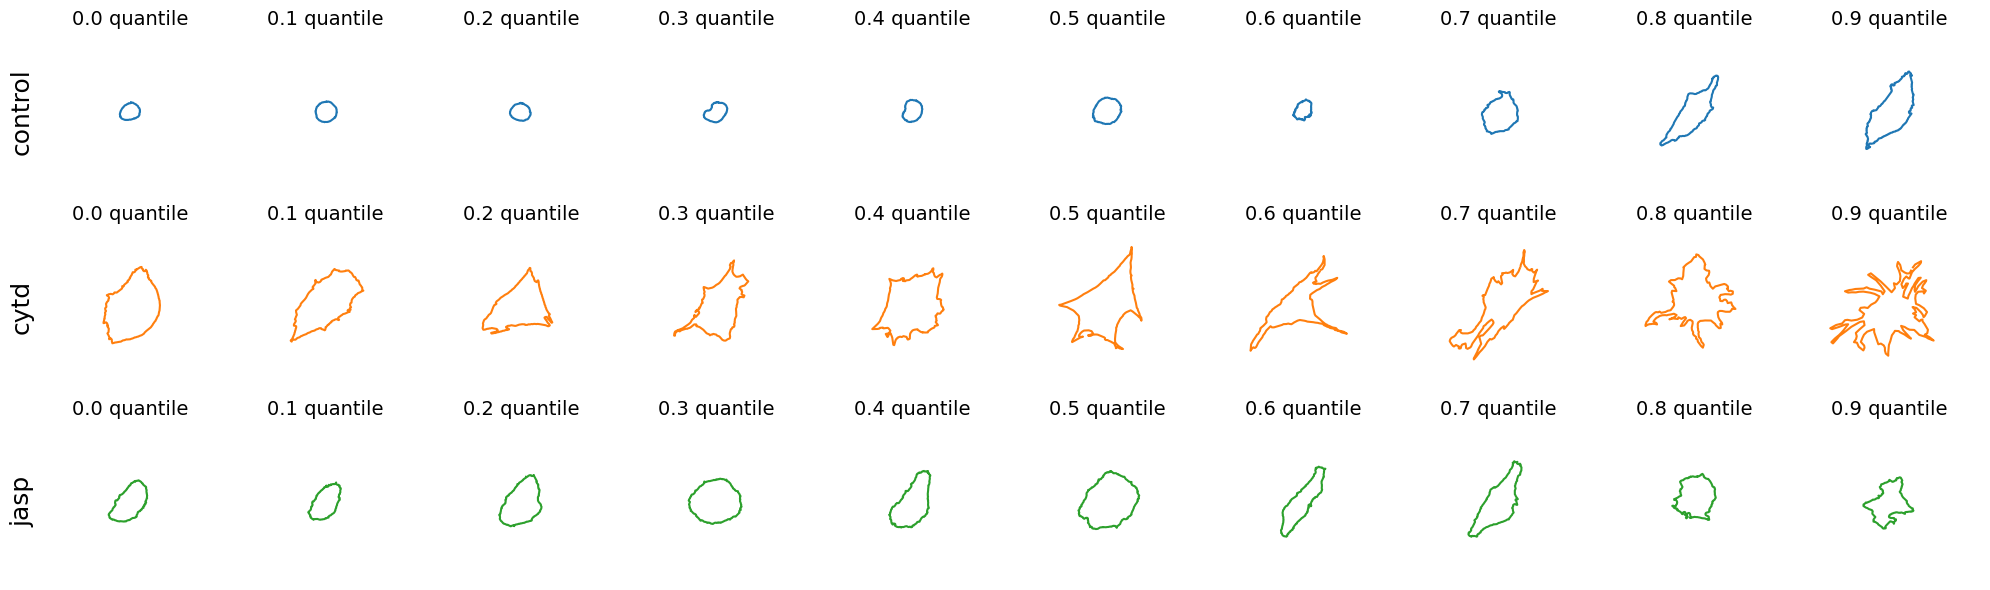

In [52]:
line = 'dlm8'
n_quantiles = 10

fig, axes = plt.subplots(
    nrows=len(TREATMENTS),
    ncols=n_quantiles,
    figsize=(20, 2 * len(TREATMENTS)),
)

metric = 'SRV'
for i, treatment in enumerate(TREATMENTS):
    dists_list = dists_to_own_mean[metric][treatment][line]
    dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
    cells_list = list(ds_align[treatment][line])
    assert len(dists_list) == len(dists_list)
    n_cells = len(dists_list)

    zipped_lists = zip(dists_list, cells_list)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
    for i_quantile in range(n_quantiles):
        quantile = int(0.1 * n_cells * i_quantile)
        one_cell = sorted_cells_list[quantile]
        ax = axes[i, i_quantile]
        ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{i}")
        ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
        # ax.axis("off")
        # Turn off tick labels
        ax.set_xlim(-170, 170)
        ax.set_ylim(-170, 170)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        if i_quantile == 0:
            ax.set_ylabel(f"{treatment}", rotation=90, fontsize=18)
plt.tight_layout()
# plt.suptitle(f"Quantiles for linear metric using own mean", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, f"{line}_quantile_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_quantile_{suffix}.pdf"))


The above code find a given number of quantiles within the distance's histogram, using linear metric and own mean, and plots the corresponding cell, for each treatment and each cell line.

Assess the correlation between own distances and cell perimeters. 

Since we consider the its category's own means rather than the global mean, we plot the correlation plot for each catogory separately. 

The Pearson coefficient between distances and perimeters for dlm8 and control is 0.92
The Pearson coefficient between distances and perimeters for dlm8 and cytd is 0.66
The Pearson coefficient between distances and perimeters for dlm8 and jasp is 0.64
The Pearson coefficient between distances and perimeters for dunn and control is 0.89
The Pearson coefficient between distances and perimeters for dunn and cytd is 0.78
The Pearson coefficient between distances and perimeters for dunn and jasp is 0.65


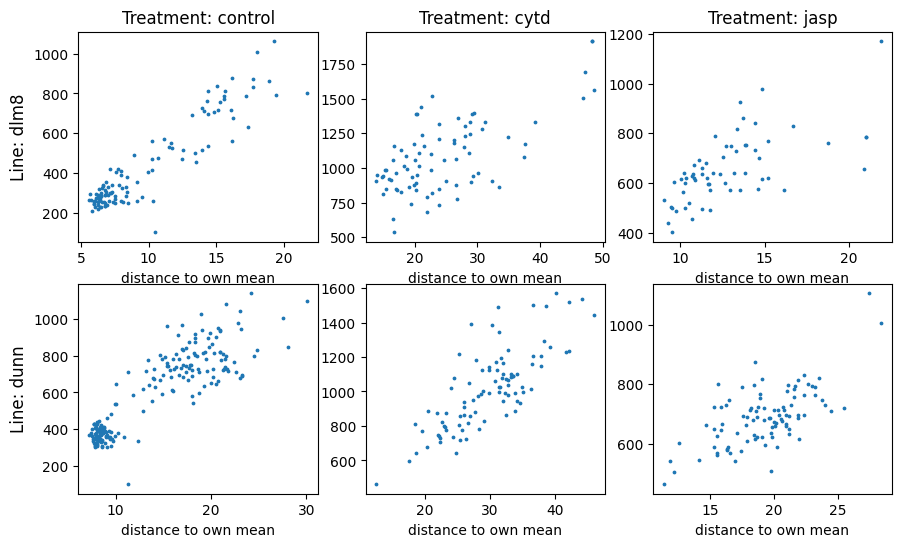

In [53]:
fig, axs = plt.subplots(len(LINES), len(TREATMENTS))
fig.set_figwidth(3.5*len(TREATMENTS))
fig.set_figheight(3*len(LINES))

for i, line in enumerate(LINES):
    for j, treatment in enumerate(TREATMENTS):
        if j == 0:
            axs[i, j].set_ylabel(f'Line: {line}', fontsize=12)
        if i == 0:
            axs[i, j].set_title(f'Treatment: {treatment}')    
        distances = dists_to_own_mean['SRV'][treatment][line]
        perimeters = ds_perimeter[treatment][line]
        axs[i, j].scatter(distances, perimeters, s=3)
        axs[i, j].set_xlabel("distance to own mean")
        # axs[i, j].set_ylabel("perimeter")

        coef, _ = pearsonr(distances, perimeters)
        print(f"The Pearson coefficient between distances and perimeters for {line} and {treatment} is {round(coef, 2)}")

plt.savefig(os.path.join(figs_dir, f"own_distance_perimeter.svg"), bbox_inches='tight')
plt.savefig(os.path.join(figs_dir, f"own_distance_perimeter.pdf"), bbox_inches='tight')

# Dimensionality Reduction

We use the following experiments to illustrate how SRV metric can help with dimensionality reduction 

In [54]:
from numba import jit, njit, prange

def srv_dist(cell1, cell2):
    return CURVES_SPACE_SRV.metric.dist(cell1, cell2) / k_sampling_points
 
def linear_dist(cell1, cell2):
    return gs.linalg.norm(cell1 - cell2) / k_sampling_points

In [55]:
pairwise_dists = {}
pairwise_dists['SRV'] = parallel_dist(cell_shapes, srv_dist, k_sampling_points)
pairwise_dists['Linear'] = parallel_dist(cell_shapes, linear_dist, k_sampling_points)

INFO: finding looplift candidates
/home/wanxinli/dyn/dyn/notebooks/common.py:26: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "parallel_dist" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/wanxinli/dyn/dyn/notebooks/common.py (29)

File "common.py", line 29:
def parallel_dist(cells, dist_fun, k_sampling_points):
    <source elided>
    pairwise_dists = np.zeros((cells.shape[0], cells.shape[0]))
    for i in prange(cells.shape[0]):
    ^

  @jit(nopython=False, forceobj=True)


Calculate MDS stress statistics for dimension 2 to 10

In [56]:
def scaled_stress(unscaled_stress, pairwise_dists):
    """ 
    Calculate the scaled stress invariant to scaling using the original stress \
    statistics and actual pairwise distances

    :param float unscaled_stress: the original stress
    :param 2D np.array[float] pairwise_dists: pairwise distance
    """
    
    return unscaled_stress/np.sqrt(np.sum(pairwise_dists**2))


In [78]:
from sklearn import manifold

mds = {}
pos = {}
dims = range(2, 11)
stresses = {}

for metric in METRICS:
    mds[metric] = {}
    pos[metric] = {}
    stresses[metric] = []
    for dim in dims:
        mds[metric][dim] = manifold.MDS(n_components=dim, random_state=1, dissimilarity="precomputed")
        pos[metric][dim] = mds[metric][dim].fit(pairwise_dists[metric]).embedding_
        unscaled_stress_val = mds[metric][dim].stress_
        scaled_stress_val = scaled_stress(unscaled_stress_val, pairwise_dists[metric])

        print(f"the stress for {metric} model is for {dim}:", scaled_stress_val)
        stresses[metric].append(scaled_stress_val)

the stress for SRV model is for 2: 0.021965797792664093
the stress for SRV model is for 3: 0.01434079610201523


the stress for SRV model is for 4: 0.010560680995839712
the stress for SRV model is for 5: 0.008505262708217535
the stress for SRV model is for 6: 0.007011873028909221
the stress for SRV model is for 7: 0.0060349444552365615
the stress for SRV model is for 8: 0.005260310799739192
the stress for SRV model is for 9: 0.004698940435298157
the stress for SRV model is for 10: 0.004251960393667587
the stress for Linear model is for 2: 0.11680257478888469
the stress for Linear model is for 3: 0.07317761196821464
the stress for Linear model is for 4: 0.05253056609372569
the stress for Linear model is for 5: 0.04567902284160187
the stress for Linear model is for 6: 0.0377018551022335
the stress for Linear model is for 7: 0.03358682699131002
the stress for Linear model is for 8: 0.030310644695964308
the stress for Linear model is for 9: 0.027285371782093736
the stress for Linear model is for 10: 0.02693766149332723


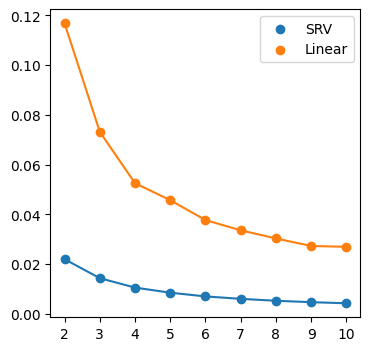

In [79]:
plt.figure(figsize = (4,4))
for metric in METRICS:
    plt.scatter(dims, stresses[metric], label=metric)
    plt.plot(dims, stresses[metric])
plt.xticks(dims)
plt.legend()
plt.savefig(os.path.join(figs_dir, f"MDS_stress_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"MDS_stress_{suffix}.pdf"))

MDS embedding of cell treatments (control, cytd and jasp) for different cell lines (dunn and dlm8)

In [59]:
dims = range(2, 4)
embs = {}

for metric in METRICS:
    embs[metric] = {}
    for dim in dims:
        embs[metric][dim] = {}
        index = 0
        for treatment in TREATMENTS:
            embs[metric][dim][treatment] = {}
            for line in LINES:
                cell_num = len(ds_align[treatment][line])   
                pos[metric][dim][index:index+cell_num]
                embs[metric][dim][treatment][line] = pos[metric][dim][index:index+cell_num]
                index += cell_num

In [60]:
embs['SRV'][3]['control']['dlm8'].shape

(114, 3)

We draw a comparison with linear metric using the following code

The stress for MDS embedding using the linear metric is better than SRV metric. 

However, if we can make a better interpretation of the visual result of SRV metric, we could still argue SRV is better at capturing cell heterogeneity. 

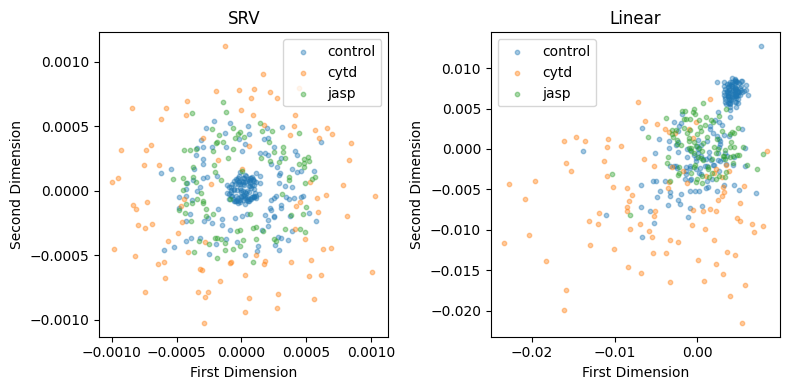

In [61]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

dim = 2
line = 'dunn'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][dim][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using SRV metric", fontsize=20)

plt.tight_layout()

plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D_{suffix}.pdf"))


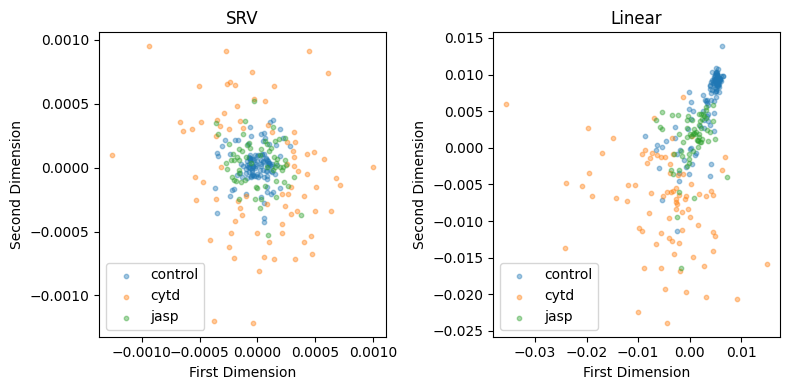

In [62]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

dim = 2
line = 'dlm8'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][dim][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using SRV metric", fontsize=20)

plt.tight_layout()

plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D_{suffix}.pdf"))


We also consider embedding in 3D. 

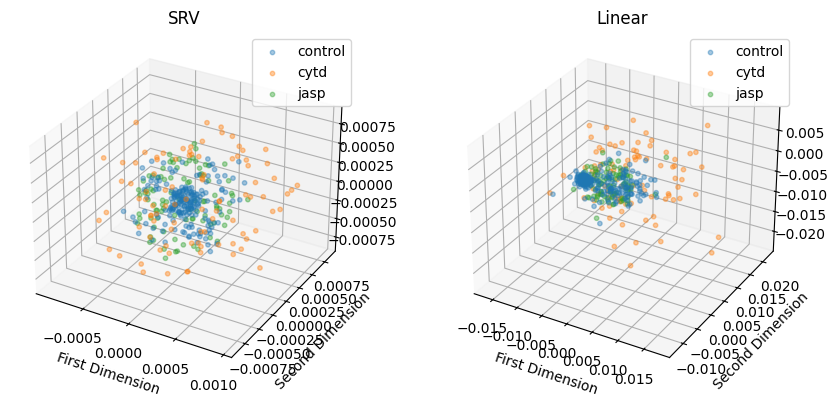

In [63]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(9, 4), subplot_kw=dict(projection='3d'))

dim = 3
line = 'dunn'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][dim][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                cur_embs[:, 2],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using linear metric", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D_{suffix}.pdf"))


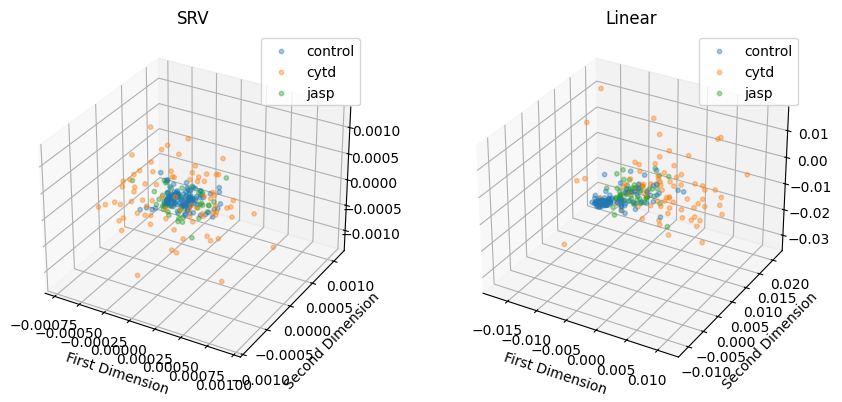

In [64]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(9, 4), subplot_kw=dict(projection='3d'))

dim = 3
line = 'dlm8'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][dim][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                cur_embs[:, 2],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using linear metric", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D_{suffix}.pdf"))


Calculate the Frobenius norm 

In [65]:
ds_proc

{'control': {'dlm8': array([[[ 916.        , -603.        ],
          [ 914.95001221, -604.        ],
          [ 914.        , -604.40002441],
          ...,
          [ 920.        , -604.15002441],
          [ 919.09997559, -604.        ],
          [ 918.04998779, -603.04998779]],
  
         [[ 952.        , -137.        ],
          [ 951.2800293 , -137.72000122],
          [ 950.55999756, -138.        ],
          ...,
          [ 957.15997314, -139.16000366],
          [ 955.32000732, -139.        ],
          [ 953.44000244, -138.44000244]],
  
         [[ 530.        , -733.        ],
          [ 529.73999023, -733.26000977],
          [ 529.47998047, -733.52001953],
          ...,
          [ 533.90002441, -733.        ],
          [ 532.59997559, -733.        ],
          [ 531.29998779, -733.        ]],
  
         ...,
  
         [[1051.        ,  -53.        ],
          [1050.63500977,  -53.36500168],
          [1050.27001953,  -53.72999954],
          ...,
          

In [66]:
def calc_norm(cell_shape):
    """ 
    Calculates the Frobenius norm of the cell shape in 2D
    """

    total_space_metric = PRESHAPE_SPACE._get_total_space_metric()
    centered_point = PRESHAPE_SPACE.center(cell_shape)
    frob_norm = total_space_metric.norm(centered_point)
    return frob_norm

In [67]:
ds_size = apply_func_to_ds(ds_proc, func= lambda x: calc_norm(x))


In [68]:
print(xx)

[ 169.          173.46231156  177.92462312  182.38693467  186.84924623
  191.31155779  195.77386935  200.2361809   204.69849246  209.16080402
  213.62311558  218.08542714  222.54773869  227.01005025  231.47236181
  235.93467337  240.39698492  244.85929648  249.32160804  253.7839196
  258.24623116  262.70854271  267.17085427  271.63316583  276.09547739
  280.55778894  285.0201005   289.48241206  293.94472362  298.40703518
  302.86934673  307.33165829  311.79396985  316.25628141  320.71859296
  325.18090452  329.64321608  334.10552764  338.5678392   343.03015075
  347.49246231  351.95477387  356.41708543  360.87939698  365.34170854
  369.8040201   374.26633166  378.72864322  383.19095477  387.65326633
  392.11557789  396.57788945  401.04020101  405.50251256  409.96482412
  414.42713568  418.88944724  423.35175879  427.81407035  432.27638191
  436.73869347  441.20100503  445.66331658  450.12562814  454.5879397
  459.05025126  463.51256281  467.97487437  472.43718593  476.89949749
  481.36

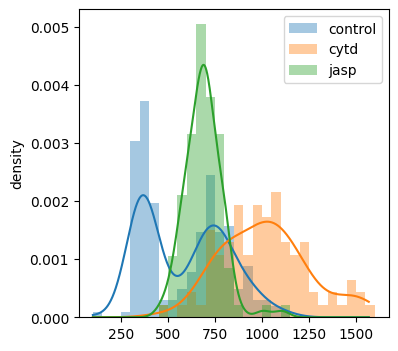

In [69]:
line = 'dunn'
min_size = min(ds_size['control'][line])
max_size = max(ds_size['cytd'][line])
xx = gs.linspace(min_size, max_size, 1000)

w=50
plt.figure(figsize=(4,4))
for i, treatment in enumerate(TREATMENTS):
    sizes = ds_size[treatment][line]
    kde = stats.gaussian_kde(sizes)
    plt.plot(xx, kde(xx), color=f"C{i}")
    plt.hist(sizes, label=treatment, bins=np.arange(min_size, max_size + w, w), alpha=0.4, density=True)
plt.ylabel("density")
plt.legend()

plt.savefig(os.path.join(figs_dir, f"cell_sizes_{suffix}.svg"), bbox_inches='tight')
plt.savefig(os.path.join(figs_dir, f"cell_sizes_{suffix}.pdf"), bbox_inches='tight')

# Binary classification based on the results from MDS

We now consider one cell line at the same time, to investigate the effects of the drugs on the cell shapes. Applying the MDS again gives the following results:

In [70]:
def knn_score(pos, labels):
    clf = KNeighborsClassifier(n_neighbors=4)
    scores = cross_val_score(clf, pos, labels, cv=5, scoring='accuracy')
    return scores.mean()

In [74]:
lines = np.array(lines)
treatments = np.array(treatments)

In [76]:
for line in LINES:
    for metric in METRICS:
        control_indexes = gs.where((lines == line) & (treatments == "control"))[0]
        cytd_indexes = gs.where((lines == line) & (treatments == "cytd"))[0]
        jasp_indexes = gs.where((lines == line) & (treatments == "jasp"))[0]

        indexes = gs.concatenate((jasp_indexes, cytd_indexes, control_indexes))
        matrix = pairwise_dists[metric][indexes][:, indexes]

        mds = manifold.MDS(n_components=2, random_state = 1, dissimilarity="precomputed")
        pos = mds.fit(matrix).embedding_

        line_treatments = treatments[lines == line]
        line_treatments_strings, line_treatments_labels = np.unique(line_treatments, return_inverse=True)

        print(f'Score for {line} using {metric} is: {round(knn_score(pos, line_treatments_labels), 3)}')



Score for dlm8 using SRV is: 0.473
Score for dlm8 using Linear is: 0.563
Score for dunn using SRV is: 0.566
Score for dunn using Linear is: 0.553
